<a href="https://colab.research.google.com/github/itssofiarce/AA2-TP2-Alomar-Arce/blob/main/ej_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descripción:
En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a oraciones habladas en distintos idiomas.

Dataset:
https://www.tensorflow.org/datasets/catalog/xtreme_s


El dataset proporcionado incluye diversos sub-datasets correspondientes a oraciones habladas en distintos idiomas. Utilizaremos un subconjunto de estos datasets para entrenar un clasificador de idiomas hablados.

Objetivo:
Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir el idioma correspondiente.

Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:

Modelo convolucional sobre los espectrogramas de los clips.
Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtención de espectrogramas a partir de clips de audio.

# Librerías

In [1]:
#rm -rf data

In [2]:
!pip install tensorflow

In [3]:
!pip install pydub

In [4]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import tensorflow as tf
import tensorflow_datasets as tfds #  La versión estable, lanzada cada pocos meses.
import pandas as pd
from typing import Optional
from tensorflow_datasets.core import dataset_info # de aca viene el dataset

# Construcción y carga del Dataset


In [5]:
tfds.builder('xtreme_s').info # full_name

tfds.core.DatasetInfo(
    name='xtreme_s',
    full_name='xtreme_s/fleurs.af_za/2.0.0',
    description="""
    FLEURS is the speech version of the FLORES machine translation benchmark, covering 2000 n-way parallel sentences in n=102 languages.
    XTREME-S covers four task families: speech recognition, classification, speech-to-text translation and retrieval. Covering 102
    languages from 10+ language families, 3 different domains and 4
    task families, XTREME-S aims to simplify multilingual speech
    representation evaluation, as well as catalyze research in “universal” speech representation learning.
    
    In this version, only the FLEURS dataset is provided, which covers speech
    recognition and speech-to-text translation.
    """,
    config_description="""
    FLEURS is the speech version of the FLORES machine translation benchmark, covering 2000 n-way parallel sentences in n=102 languages.
    """,
    homepage='https://arxiv.org/abs/2205.12446',
    data_dir=PosixGPa

In [6]:
#DATASET_PATH = 'data'

#data_dir = pathlib.Path(DATASET_PATH)
#lan = {'español':'es_419', 'ingles': 'en_us', 'frances':'fr_fr', 'japones': 'ja_jp'}

In [7]:
#for key, value in lan.items():
#    # Traigo solamente una parte del subset de test para agilizar la carga
#    tfds.load(f'xtreme_s/fleurs.{value}', split='test[:1%]', shuffle_files=False, data_dir=data_dir / key)
#
#    # Limpiar y quedarme unicamente con los audios que me insteresan
#    !mv data/{key}/downloads/audio data/{key}
#    !rm -rf data/{key}/downloads
#    !rm -rf data/{key}/xtreme_s


In [8]:
from google.colab import drive
drive.mount('/content/drive')
# Con dataset reducido
df_audio = ('/content/drive/MyDrive/dataset_reducido')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!rm -rf /content/audio_sets

In [10]:
! [ ! -d /content/audio_sets ] &&  mkdir /content/audio_sets
! cp -r /content/drive/MyDrive/dataset_reducido/* /content/audio_sets/

In [11]:
drive.flush_and_unmount() # para liberar espacio

In [12]:
df = '/content/audio_sets'
data_dir = pathlib.Path(df)

In [13]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=None,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 800 files belonging to 4 classes.
Using 640 files for training.
Using 160 files for validation.

label names: ['español' 'frances' 'ingles' 'japones']


# Distribuciones de las clases


In [14]:
for dir in os.listdir(df):
    print(f'{dir}: {len(os.listdir(os.path.join(df, dir)))}')

frances: 200
español: 200
ingles: 200
japones: 200


Las clases estan balanceadas.

# Analisis Exploratorio


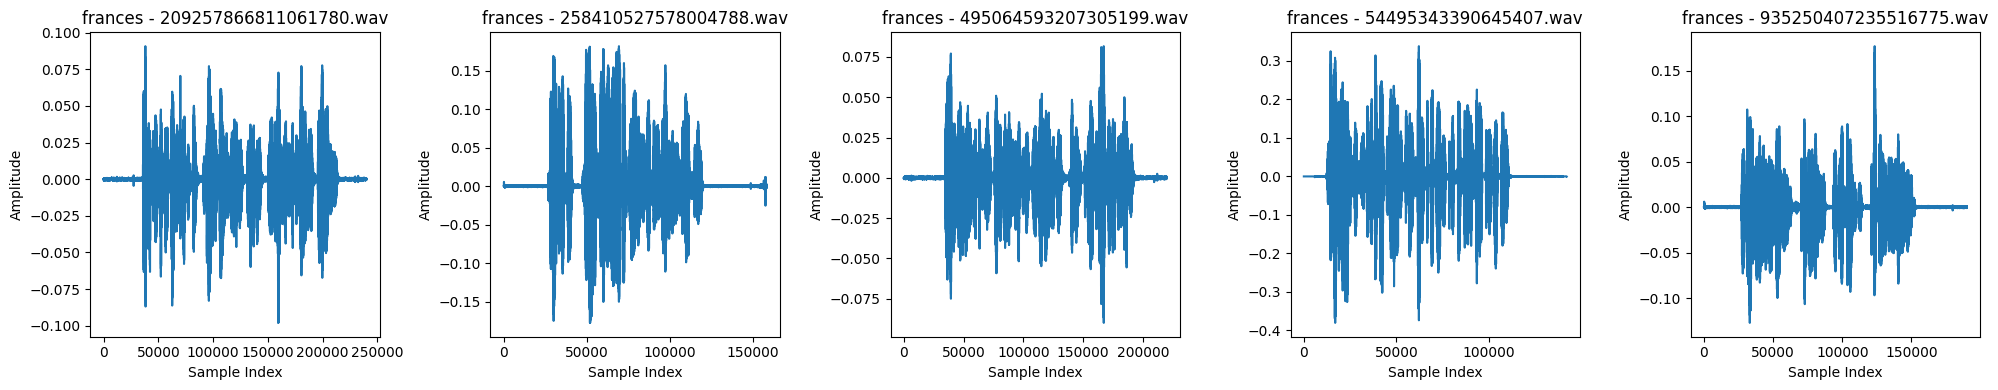

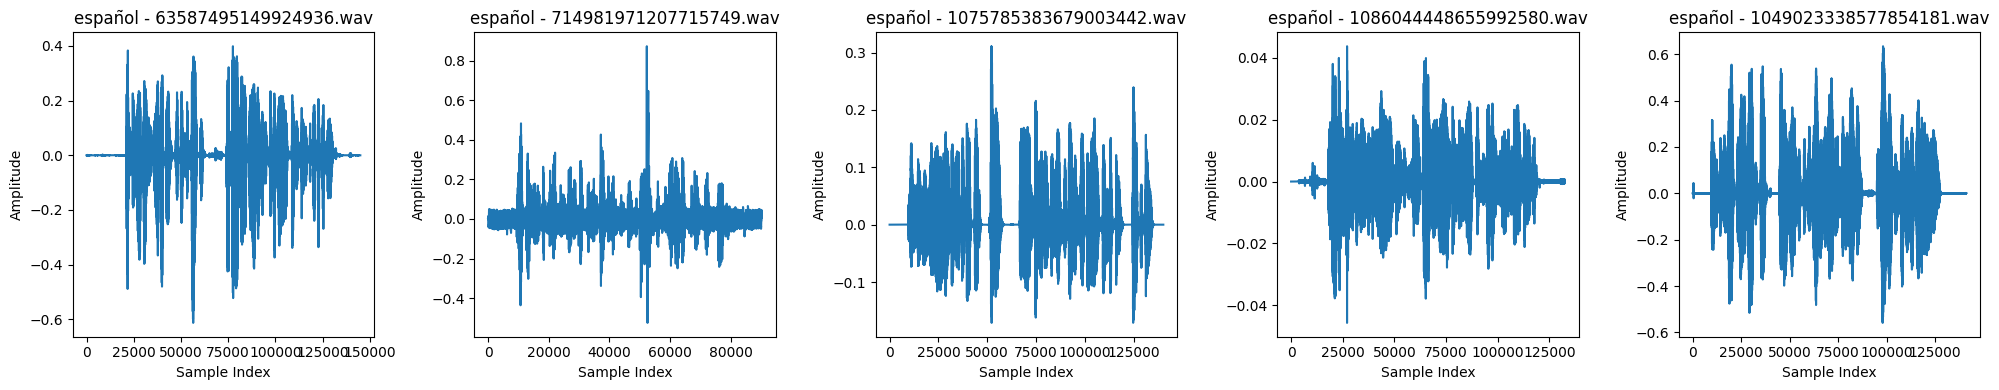

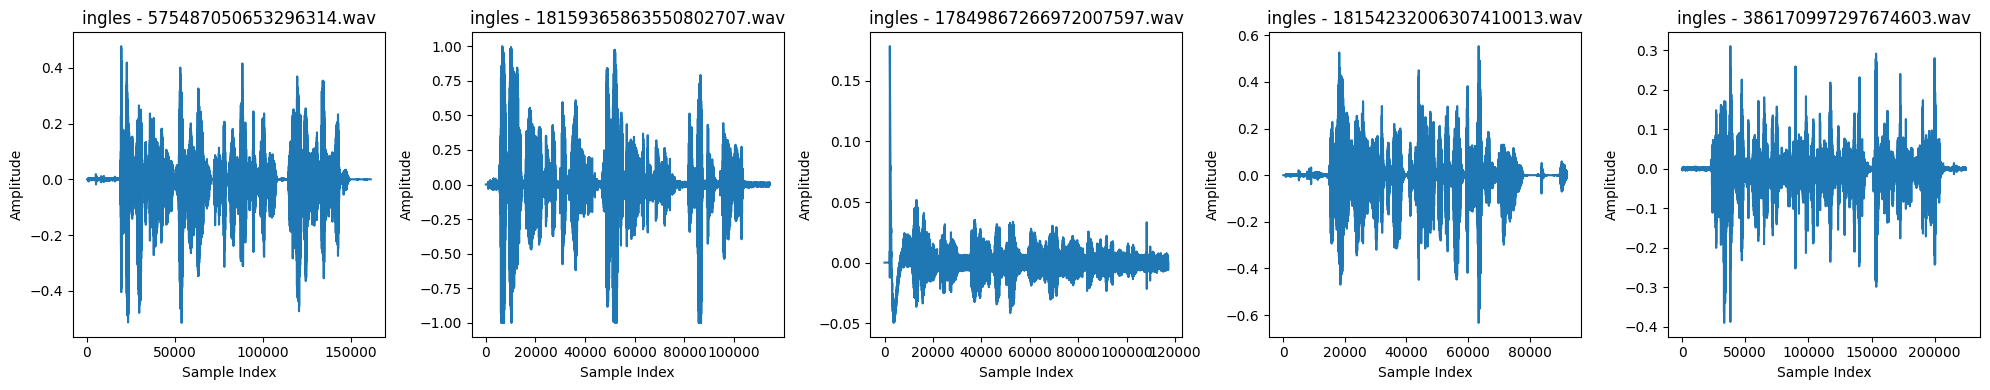

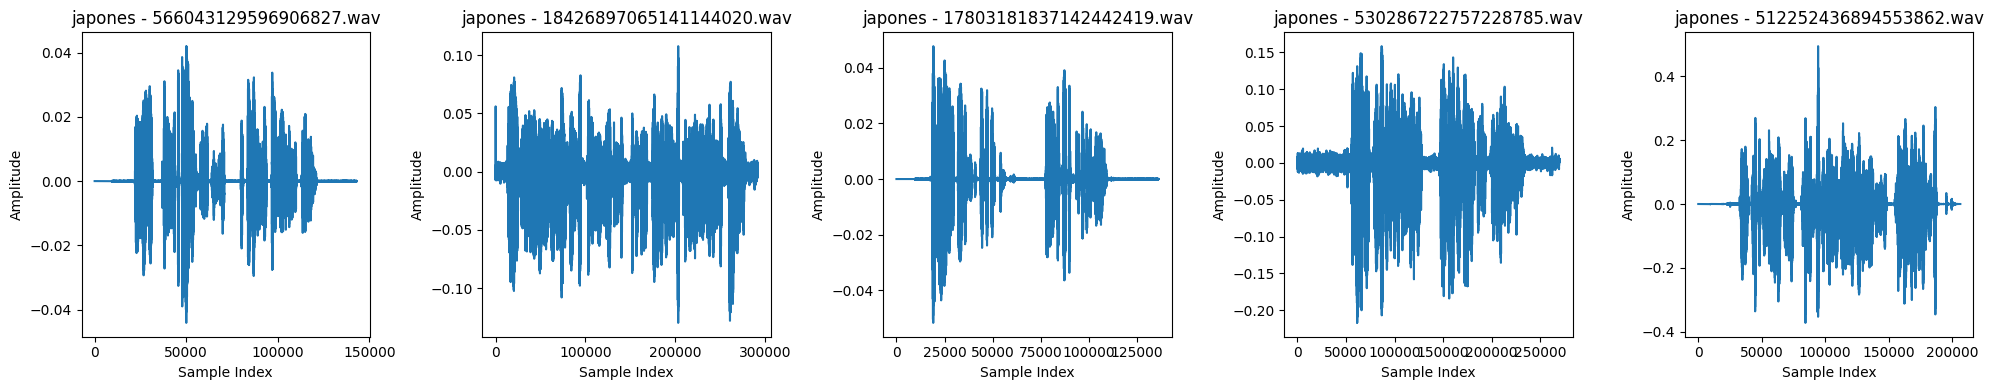

In [15]:
for dir in os.listdir(df):
    current_dir_path = os.path.join(df, dir)
    plt.figure(figsize=(20, 4))

    count = 1

    for wav in os.listdir(current_dir_path):
        if wav.endswith(".wav"):
            wav_path = os.path.join(current_dir_path, wav)
            audio = tf.audio.decode_wav(tf.io.read_file(wav_path))[0]
            plt.subplot(1, 5, count)
            plt.plot(audio.numpy())
            plt.title(f'{dir} - {wav}')
            plt.xlabel('Sample Index')
            plt.ylabel('Amplitude')

            count += 1
            if count > 5:
                break

    plt.tight_layout()
    plt.show()

Segun los los primeros 5 wav files de cada idioma, la longitud de los audios varían entre 10kHz y 30kHz vemos la dimension de los audios.

In [16]:
train_ds.element_spec

(TensorSpec(shape=(None, None, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

**shape=(None, 16000, None)**
  - Batch Size: No tiene
  - Audio Samples: No seteamos nigun output_sequence_length, por lo que a las secuencias del mismo bache se les agregó padding de la longitud del audio mas largo.
  - Numero de canales: Mono

**dtype=tf.int32:**
 - Tipo de Dato: Int32

**name=None**
  - Nombre: No tiene


Al ser audios mono, vamos a dropear el 3 componente de shape para mejorar la eficiencia y compatibilidad a la hora de entrenar el modelo con las capas que esperan 2D.


In [17]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Con .shard() spliteamos el dataset de validacion en dos mitades (num_shards=2), la primer mitad se la asignamos a test (index=0) y la segunda a validacion (index=1). Esto lo hacemos para subsanar a *audio_dataset_from_directory* ya que solo devuelve hasta dos sets (train y validación) y poder así obtener métricas mas significativas de nuestro modelo.

In [18]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Verificamos que el shape haya quedado de dos dimensiones.

In [19]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 318720)
(64,)


Ploteamos nuevamente las ondas de los audios.

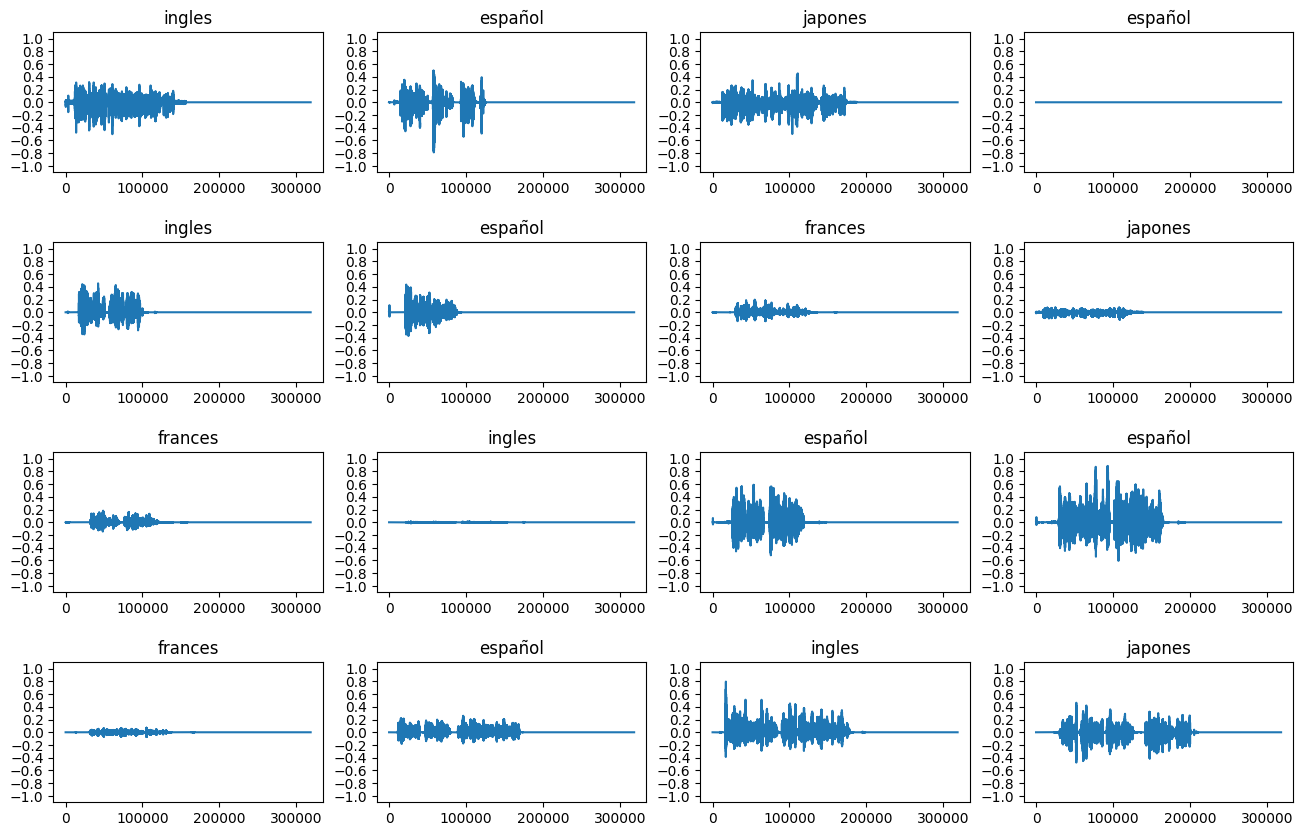

In [20]:
plt.figure(figsize=(16, 10))
rows = 4
cols = 4
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.subplots_adjust(hspace=0.5)
  plt.ylim([-1.1, 1.1])

Al reducir los canales las ondas se vuelven mas "simples" en algunos clips hasta parece no haber sonido. Seguiremos por convertirlas en espectogramas y observar el cambio de frecuencias a través del tiempo. Y poder entrar a nuestro modelo con esas imagenes representadas en 2D.

# Espectogramas


In [21]:
def get_spectrogram(waveform):
  ''' Params:
      - waveform: los clips de los audios de la misma longitud. (nuestro dataset fue armado así)'''
  # STFT a diferencia de fft splitea la señal en ventans de timepo y calcula la transformadad de fourier para cada una, preservando algo del tiempo.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128) # el frame_length y el frame_step deben ser de forma tal que la "imagen" del espectograma sea casi cuadrada para que ...
  spectrogram = tf.abs(spectrogram) # magnitud del spectograma
  # Agrego una dimension de "canales" para que el se pueda usar la imagen del espectograma como input en las redes convolucionales
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [22]:
label_names[example_labels]

array(['ingles', 'español', 'japones', 'español', 'ingles', 'español',
       'frances', 'japones', 'frances', 'ingles', 'español', 'español',
       'frances', 'español', 'ingles', 'japones', 'español', 'frances',
       'japones', 'japones', 'frances', 'ingles', 'ingles', 'ingles',
       'ingles', 'frances', 'ingles', 'japones', 'japones', 'español',
       'ingles', 'ingles', 'ingles', 'español', 'frances', 'japones',
       'ingles', 'frances', 'frances', 'ingles', 'ingles', 'ingles',
       'japones', 'ingles', 'japones', 'ingles', 'frances', 'ingles',
       'frances', 'frances', 'japones', 'español', 'japones', 'ingles',
       'ingles', 'frances', 'frances', 'japones', 'frances', 'español',
       'español', 'frances', 'español', 'frances'], dtype='<U8')

In [39]:
clean_test=[]
i = 0
while len(clean_test) < 4:
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  # Si ya mostré un audio, entonces sigo buscando uno distinto
  if label not in clean_test:
    clean_test.append(label)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=20100)) # rate es la velocidad mientras mas chico, mas lento.
  else:
    pass
  i += 1

Label: ingles
Waveform shape: (318720,)
Spectrogram shape: (2489, 129, 1)
Audio playback


Label: español
Waveform shape: (318720,)
Spectrogram shape: (2489, 129, 1)
Audio playback


Label: japones
Waveform shape: (318720,)
Spectrogram shape: (2489, 129, 1)
Audio playback


Label: frances
Waveform shape: (318720,)
Spectrogram shape: (2489, 129, 1)
Audio playback


Graficamos

In [40]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

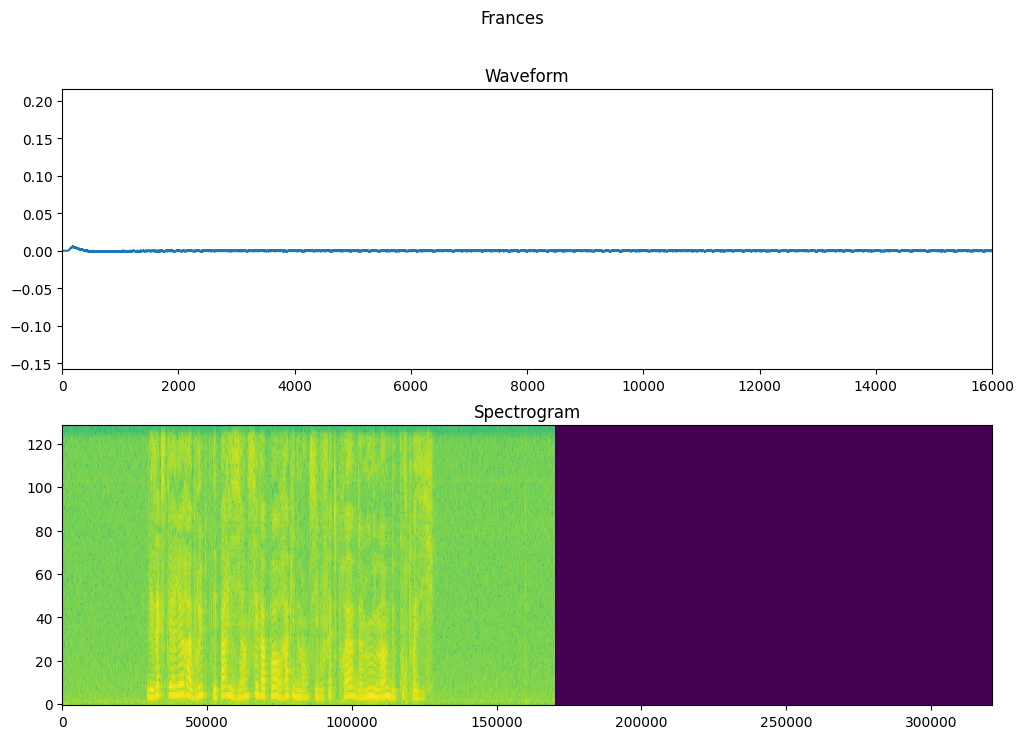

In [41]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Armamos nuestro dataset de espectogramas


In [42]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [43]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [44]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

# pending to fix


0 hello
1 hello
2 hello
3 hello
4 hello
5 hello
6 hello
7 hello
8 hello
9 hello


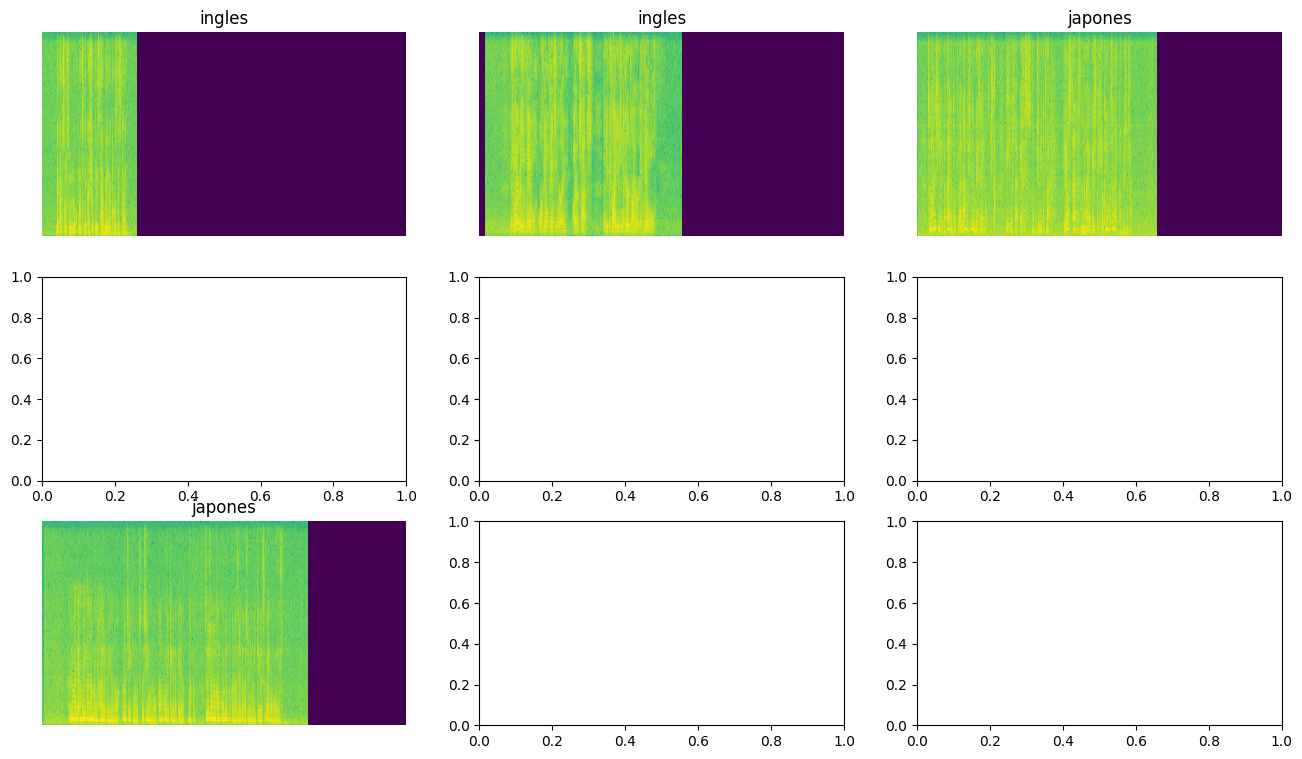

In [59]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

clean_spec=[]
i=0
while i != 10:
  print(i, "hello")
  label = label_names[example_labels[i]]

  # Si ya mostré un audio, entonces sigo buscando uno distinto
  if label not in clean_spec:

    clean_spec.append(label)
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])
    ax.axis('off')

  i += 1
  pass

plt.show()

# Modelo Convolucional

In [61]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [77]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (2361, 129, 1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_7 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,095 (6.20 MB)

 Trainable params: 1,625,092 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [78]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [79]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.2977 - loss: 1.4002 - val_accuracy: 0.3438 - val_loss: 1.3865
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3658 - loss: 1.2880 - val_accuracy: 0.3750 - val_loss: 1.3457
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4262 - loss: 1.2338 - val_accuracy: 0.4219 - val_loss: 1.3238
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5034 - loss: 1.1411 - val_accuracy: 0.4844 - val_loss: 1.2638
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5149 - loss: 1.0950 - val_accuracy: 0.4844 - val_loss: 1.2959
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5659 - loss: 1.0453 - val_accuracy: 0.4688 - val_loss: 1.3341
Epoch 6: early stopping


# Analisis de las métricas


Text(0, 0.5, 'Accuracy [%]')

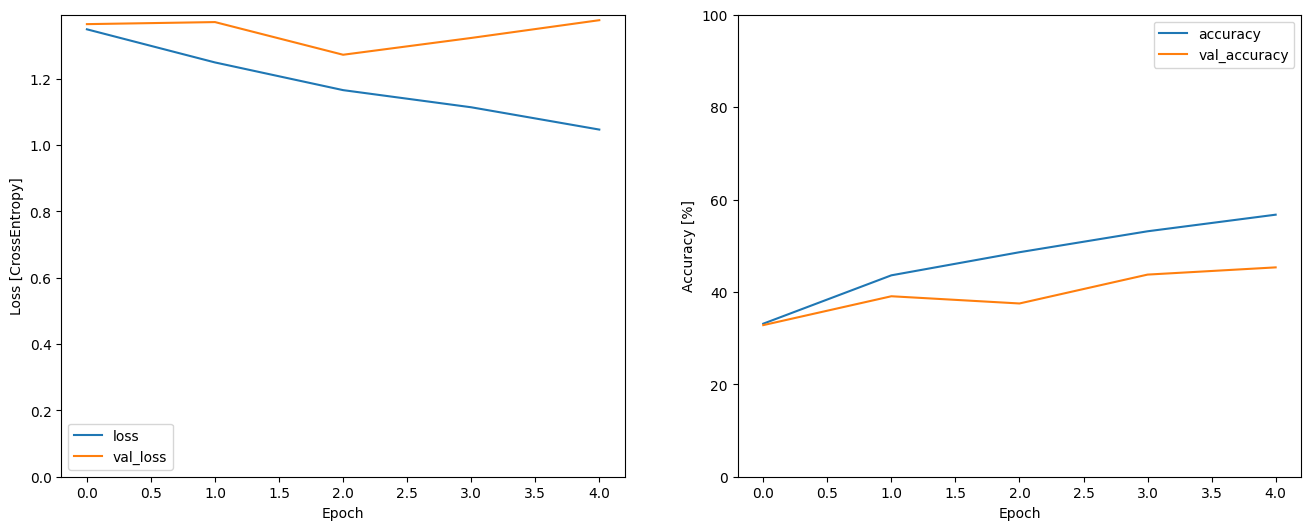

In [65]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [66]:
model.evaluate(test_spectrogram_ds, return_dict=True)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4740 - loss: 1.2307


{'accuracy': 0.46875, 'loss': 1.2317008972167969}

In [67]:
y_pred = model.predict(test_spectrogram_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 872ms/step


In [68]:
y_pred = tf.argmax(y_pred, axis=1)

In [69]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

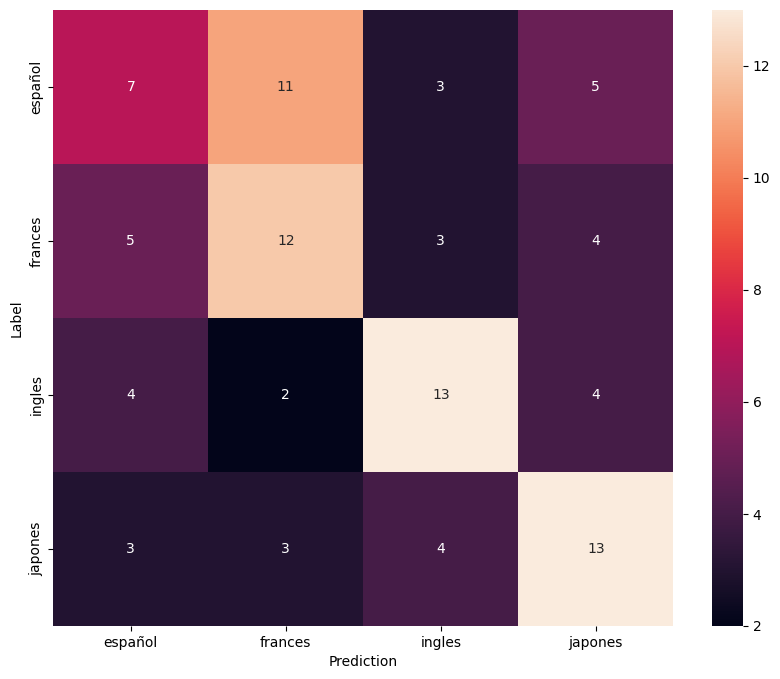

In [70]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Conlcusión del modelo convolucional:

# Modelo Recurrente

In [76]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))
model.summary()

Input shape: (2361, 129, 1)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)